### Fig DESeq Summary (Fig. 5 & Fig. S5)
- 5A: Scatterplot to show correlation between depleted and input quantseq using CPM from HTSeq quantification.
- 5B: MA plot of depleted vs. input quant-seq
- 5C: Bar plot for complementarity to the probes for genes going down + depletion vs other genes.   
Make associated supplemental fig 5:
Used the Stellar aligner to find regions of complementarity between the probes and the rRNAs and other genes
- S5A: complementarity length vs. % identity for genes complementary to probes
- S5B: complementarity length vs. % identity for genes complementary to rRNAs

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats
import itertools
import matplotlib.ticker as plticker
import shutil

sys.path.append('../scripts/')
from plot_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

db = gffutils.FeatureDB(gffutils_db)

In [2]:
outdir = '../figures/F5/'
os.makedirs(outdir, exist_ok = True)

In [3]:
#Load gene biotypes:
biotype_dict = {}
for i in db.all_features(featuretype = 'gene'):
    this_gene = i.id
    try:
        biotype = db[this_gene].attributes['gene_biotype'][0]
        genename = db[this_gene].attributes['gene_name'][0]
        #change biotype to rRNA if rRNA is in the name -- occurs for some pseudogenes
        if 'rRNA' in genename:
            biotype = 'rRNA'
            
    except KeyError:
        biotype = 'spike-in' #only the spike-ins don't have a biotype
        
    biotype_dict[this_gene] = biotype

In [4]:
#the htseq quantification file
htseq_file = os.path.join(results_dir, 'rnaseq_data_200723/gene_quantification/summary_abundance_by_gene_htseq.csv')
df = pd.read_csv(htseq_file)

#Drop the SIRV, spikein values and the non-gene rows
nospike_df = df[~df['gene'].apply(lambda x: (x.startswith('SIRV') or x.startswith('__')))].copy().set_index('gene')

#get CPM values
nospike_df['CPM'] = nospike_df['counts']*1e6/nospike_df.groupby(['experiment', 'replicate'])['counts'].transform('sum')

mean_df = nospike_df.groupby(['gene', 'experiment']).mean()
mean_df.reset_index('experiment', inplace = True)

In [5]:
#Get the input and subtracted values, put back together
in_df = mean_df.loc[mean_df['experiment'] == 'inputq', 'CPM'].copy()
sub_df = mean_df.loc[mean_df['experiment'] == 'subtractedq', 'CPM'].copy()
comp_df = pd.merge(in_df, sub_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
#restrict to genes with mean TPM >= 1
filtered_df = comp_df[(comp_df['CPM_in'] >= 1) & (comp_df['CPM_sub'] >= 1)].copy()
filtered_df['CPM_in_log10'] = filtered_df['CPM_in'].apply(np.log10)
filtered_df['CPM_sub_log10'] = filtered_df['CPM_sub'].apply(np.log10)
filtered_df['biotype'] = filtered_df.index.map(biotype_dict)

#get data specifically from protein coding and ncRNAs:
coding_ncRNA = ['protein_coding', 'ncRNA']
filtered_df['coding_ncRNA'] = filtered_df['biotype'].isin(coding_ncRNA)
cfilt_df = filtered_df[filtered_df['coding_ncRNA']].copy()

rval, pval = scipy.stats.pearsonr(cfilt_df['CPM_in'], cfilt_df['CPM_sub'])
r2_val_av = rval**2
print('r2 val from averages', r2_val_av)

r2 val from averages 0.935091481025752


In [6]:
#Get the r2 values between subtracted and input for each replicate
exps = ['inputq', 'subtractedq']
reps = ['rep1', 'rep2', 'rep3']
#get data specifically from protein coding and ncRNAs:
nospike_df['biotype'] = nospike_df.index.map(biotype_dict)
nospike_df['coding_ncRNA'] = nospike_df['biotype'].isin(coding_ncRNA)
cnc_df = nospike_df[nospike_df['coding_ncRNA']].copy()

rep_df = cnc_df.set_index(['experiment', 'replicate'], append = True)

#Get r**2 for depleted vs. input samples at each replicate
for r in reps:
    print(r)
    x_df = rep_df.loc[pd.IndexSlice[:, exps[0], r], 'CPM'].reset_index(['experiment', 'replicate'])
    y_df = rep_df.loc[pd.IndexSlice[:, exps[1], r], 'CPM'].reset_index(['experiment', 'replicate'])
    c_df = pd.merge(x_df, y_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
    f_df = c_df[(c_df['CPM_in'] >= 1) & (c_df['CPM_sub'] >= 1)].copy()
    rval, pval = scipy.stats.pearsonr(f_df['CPM_in'], f_df['CPM_sub'])
    r2_val = rval**2
    print(r2_val)

rep1
0.9435917453761333
rep2
0.8884779296223968
rep3
0.9506970994140393


In [7]:
#Get the interreplicate r2 values
for e in exps:
    print('experiment: %s' % e)
    for c in itertools.combinations(reps, 2):
        print('%s\t%s' % (c[0], c[1]))
        x_df = rep_df.loc[pd.IndexSlice[:, e, c[0]], 'CPM'].reset_index(['experiment', 'replicate'])
        y_df = rep_df.loc[pd.IndexSlice[:, e, c[1]], 'CPM'].reset_index(['experiment', 'replicate'])
        c_df = pd.merge(x_df, y_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
        f_df = c_df[(c_df['CPM_in'] >= 1) & (c_df['CPM_sub'] >= 1)].copy()
        rval, pval = scipy.stats.pearsonr(f_df['CPM_in'], f_df['CPM_sub'])
        r2_val = rval**2
        print(r2_val)

experiment: inputq
rep1	rep2
0.9612159001240881
rep1	rep3
0.9501540563680244
rep2	rep3
0.8643445768888421
experiment: subtractedq
rep1	rep2
0.9811717421669452
rep1	rep3
0.9354702058719863
rep2	rep3
0.8940539713313329


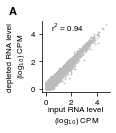

In [8]:
#Plot the correlation between input and depleted libraries
panel_name = '5A'
plot = Plotter(corners = [0.27, 0.27, 0.6, 0.6], figsize = (sfig, sfig))

plot.nudge_corners(left = True, right = True)

plot.setup_axis()
pointsize = 0.5

plot.ax.scatter(cfilt_df['CPM_in_log10'], cfilt_df['CPM_sub_log10'], s = pointsize)
plot.set_ylabel('depleted RNA level\n (log'r'$_{10}$'') CPM', nudge = (0.015, 0))
plot.set_xlabel('input RNA level\n (log'r'$_{10}$'') CPM')
loc = plticker.MultipleLocator(base=2.0)
plot.ax.xaxis.set_major_locator(loc)
plot.ax.yaxis.set_major_locator(loc)

plot.ax.set_xlim(-0.25, 5)
plot.ax.set_xlim(-0.25, 5)
plot.ax.text(0.4, 4.2, 'r'r'$^2$'' = %1.2f' % r2_val_av, fontsize = 8)

plot.add_letter('A', ha = 'right')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [9]:
#Fig 5B, quantifying probe matches of downregulated genes vs. other genes
def get_count_table(df, value, category):
    '''
    Return a dataframe containing counts of
    a specific value. For example length or bitscore.
    Create a column labeled category with the name for the bar plot
    '''
    count_s = df[value].value_counts().to_frame().rename(columns = {value:'counts'})
    count_df = pd.DataFrame(count_s)
    count_df['percent_counts'] = (count_df['counts']/count_df['counts'].sum())*100
    count_df[value] = count_df.index
    label = '%s\n(n = %s)' % (category, count_df['counts'].sum())
    count_df['category'] = label
    return count_df, label

def add_gene(x):
    gene = next(db.parents(x, featuretype = 'gene')).id
    return gene

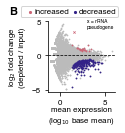

In [10]:
#Fig 5B, plot the results of the DESeq2 analysis
#https://stackoverflow.com/questions/18773662/python-scatter-plot-logarithmic-scale
panel_name = '5B'

deseq_file = os.path.join(results_dir, 'rnaseq_data_200723/diffexp_htseq/subtractedq-vs-inputq.diffexp.csv')
deseq_df = pd.read_csv(deseq_file, index_col = 0)
deseq_df['log10_baseMean'] = deseq_df['baseMean'].apply(np.log10)
#Assign genes to biotype and examine up and downregulated genes
deseq_df['biotype'] = deseq_df.index.map(biotype_dict)

padj_threshold = 0.01
deseq_df['increased'] = (deseq_df['log2FoldChange'] > 0) & (deseq_df['padj'] < padj_threshold)
deseq_df['decreased'] = (deseq_df['log2FoldChange'] < 0) & (deseq_df['padj'] < padj_threshold)

#Alternative values if padj cutoff = 0.05
padj_threshold2 = 0.05
deseq_df['increased_0.05'] = (deseq_df['log2FoldChange'] > 0) & (deseq_df['padj'] < padj_threshold2)
deseq_df['decreased_0.05'] = (deseq_df['log2FoldChange'] < 0) & (deseq_df['padj'] < padj_threshold2)

#find increased or decreased rRNAs that have non-NA values for the padj
uprrnas = deseq_df[(deseq_df['increased']) & (deseq_df['biotype'] == 'rRNA')].index
downrrnas = deseq_df[(deseq_df['decreased']) & (deseq_df['biotype'] == 'rRNA')].index
changing_rrnas = np.append(uprrnas.values, downrrnas.values)

#remove these rRNAs from the df, so that I can plot them with a different symbol
ndf = deseq_df.drop(changing_rrnas)

#make space for the legend
plot = Plotter(corners = [0.32, 0.27, 0.6, 0.6], figsize = (sfig, sfig))

plot.nudge_corners(left = True, right = True)
plot.setup_axis()

pointsize = 0.5
bg = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = ndf, s = pointsize)
up = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = ndf[ndf['increased']],
                     s = pointsize, color = color_dict['rose'])

down = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = ndf[ndf['decreased']],
                     s = pointsize, color = color_dict['indigo'])

plot.ax.axhline(y = 0, color = 'k', linestyle = '--')

plot.ax.legend([up, down], ['increased', 'decreased'], ncol = 2, bbox_to_anchor=(-0.41, 1.1, 1.45, .102),
               fontsize = 8, borderpad = 0.2, borderaxespad=0., labelspacing = 0, handletextpad = -0.5, mode = 'expand', markerscale = 3)

up_rrna = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = deseq_df.loc[uprrnas],
                     s = 5, color = color_dict['rose'], marker = 'x')

down_rrna = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = deseq_df.loc[downrrnas],
                     s = 5, color = color_dict['indigo'], marker = 'x')

#rRNA genes changing
#FBgn0267523 5.8S pseudogene -- up
#FBgn0085813 18S pseudogene -- down

ytext =  'log'r'$_{2}$' ' fold change\n(depleted / input)'
xtext = 'mean expression\n(log'r'$_{10}$' ' base mean)'
plot.set_xlabel(xtext)
plot.set_ylabel(ytext, nudge = (0.015, 0))

plot.ax.text(3, 4, 'x = rRNA\npseudogene', fontsize = 5)

#borderpad effects the box size but it is unevenly distributed - left one is still over on right a bit
plot.add_letter('B', ha = 'right')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [11]:
#Get genes that are both not rRNAs and also have an assigned padj -- this means they must also have met an expression threshold
#https://support.bioconductor.org/p/76144/
#This explains that the genes with padj NA basically don't have high enough expression to be included.

#get 'non-zero' genes (ones quantified well enough to have a non-NA padj)
nz_df = deseq_df.dropna(subset = ['padj'])

#get non-zero, non-ribo genes
non_ribo_df = nz_df[nz_df['biotype'] != 'rRNA'].copy()

decreased_genes = non_ribo_df[non_ribo_df['decreased']].index
increased_genes = non_ribo_df[non_ribo_df['increased']].index
other_genes = non_ribo_df[~non_ribo_df['decreased']].index

nonzero_genes = non_ribo_df.index
print('number non-zero genes', len(nonzero_genes))
print('number of increased genes', len(increased_genes))
print('number of down genes', len(decreased_genes))
print('number of other/non-down genes', len(other_genes))

#write non-zero genes to file to use for the Stellar homology search
with open(os.path.join(outdir,'nonzero_genes.csv'), 'w') as f:
    for i in nonzero_genes:
        f.write(f'{i}\n')
        
print('median change increased', 2**non_ribo_df.loc[increased_genes, 'log2FoldChange'].median())
change_decreased = 2**non_ribo_df.loc[decreased_genes, 'log2FoldChange'].median()
print('median change decreased', change_decreased)
print('median fc decreased', 1/change_decreased)

print('percent of non-zero genes decreased', len(decreased_genes)*100/len(nonzero_genes))

number non-zero genes 7323
number of increased genes 23
number of down genes 208
number of other/non-down genes 7115
median change increased 1.9028127532276042
median change decreased 0.46214277889342004
median fc decreased 2.1638334421116667
percent of non-zero genes decreased 2.8403659702307795


In [12]:
#Alternative values if padj cutoff = 0.05
increased_genes2 = non_ribo_df[non_ribo_df['increased_0.05']].index
decreased_genes2 = non_ribo_df[non_ribo_df['decreased_0.05']].index

print('number of increased genes', len(increased_genes2))
print('number of down genes', len(decreased_genes2))

print('median change increased', 2**non_ribo_df.loc[increased_genes2, 'log2FoldChange'].median())
change_decreased = 2**non_ribo_df.loc[decreased_genes2, 'log2FoldChange'].median()
print('median change decreased', change_decreased)
print('median fc decreased', 1/change_decreased)

number of increased genes 82
number of down genes 359
median change increased 1.7725287935122847
median change decreased 0.5129365645391377
median fc decreased 1.9495588131808816


In [13]:
#Fig 5C, Plot matches to genes decreased after depletion vs. other genes using Blast results
#Revised counting of probe transcriptome alignments using only the spliced and longest version of each txt:
homol_file = os.path.join(results_dir, 'probe_design_results/dmel_homol_check_200715/probeoff_e500.csv')
homol_df = pd.read_csv(homol_file, names = ['qseqid', 'sseqid', 'pident', 'length',
'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'])

#extract the plus strand alignments, since this would indicate potential probe hyb since we aligned the reverse complement
homol_df['strand'] = homol_df.apply(lambda x: 'plus' if x['send'] > x['sstart'] else 'minus', axis = 1)
pdf = homol_df[homol_df['strand'] == 'plus'].copy()
ident_df = pdf[pdf['pident'] == 100].copy()
#add gene symbol
ident_df['gene'] = ident_df['sseqid'].apply(add_gene)

#count matches to decreased genes vs. all other genes
lengths_used = [12, 13, 14, 15]
ident_df['down'] = ident_df['gene'].isin(decreased_genes)
ident_df['other'] = ident_df['gene'].isin(other_genes)
ident_df = ident_df.loc[ident_df['length'].isin(lengths_used)].copy()
gene_count_down, gene_down_label = get_count_table(ident_df[ident_df['down']], 'length', 'decreased genes')
gene_count_other, gene_other_label = get_count_table(ident_df[ident_df['other']], 'length', 'other genes')
gene_count_df = pd.concat([gene_count_down, gene_count_other])

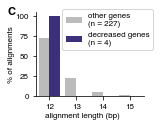

In [14]:
#Plot matches to genes decreased after depletion vs. other genes using Blast results
panel_name = '5C'

plot = Plotter(corners = [0.19, 0.24, 0.71, 0.71], figsize = (sfig*1.3, sfig))
plot.nudge_corners(left = True)
plot.setup_axis()

plot.ax = sns.barplot(x = 'length', y = 'percent_counts', 
                      hue_order = [gene_other_label, gene_down_label], 
                      hue = 'category', data = gene_count_df, 
                      palette = [color_dict['grey'], color_dict['indigo']], 
                      ax = plot.ax)


plot.set_ylabel('% of alignments')
plot.set_xlabel('alignment length (bp)', nudge = (-0.05, 0))

leg = plot.ax.get_legend().set_visible(False)
plot.ax.legend(loc = 3, ncol = 1, fontsize = label_fontsize, bbox_to_anchor=(0.21, 0.5, 1.45, .102))
plot.add_letter('C')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [15]:
#Make Fig. S5
outdir2 = '../figures/FS5/'
os.makedirs(outdir2, exist_ok = True)

In [16]:
#Fig S5A, plot matches for complementarity between probes and genes using Stellar homology search
stellar_probe_file = os.path.join(results_dir, 'probe_design_results/dmel_homol_check_200715/probes_st_26_75.gff')
stellar_df = pd.read_csv(stellar_probe_file, sep = '\t', names = ['txt_id', 'source', 'feature_type', 'start', 'end',
'percent_id', 'strand', 'phase', 'cigar'])
stellar_df['length'] = stellar_df['end'] - stellar_df['start'] + 1
stellar_df['gene'] = stellar_df['txt_id'].apply(add_gene)
stellar_df['down'] = stellar_df['gene'].isin(decreased_genes)
stellar_df['other'] = stellar_df['gene'].isin(other_genes)
odf = stellar_df[stellar_df['other']].copy()
ddf = stellar_df[stellar_df['down']].copy()
#https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
ocount = odf.groupby(['percent_id', 'length']).size().reset_index(name = 'counts')
dcount = ddf.groupby(['percent_id', 'length']).size().reset_index(name = 'counts')
ocount['gene type'] = 'other'
dcount['gene type'] = 'decreased'
bdf = pd.concat([ocount, dcount])

total alignments 9151
decreased 154
other 8997
percent of decreased alns 1.682876188394711


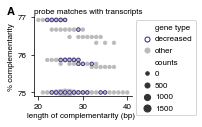

In [17]:
#Plot matches for complementarity between probes and genes using Stellar homology search
loc = plticker.MultipleLocator(base=1.0)
panel_name = 'S5A'

plot = Plotter(corners = [0.14, 0.24, 0.52, 0.67], figsize = (sfig*1.65, sfig))

plot.nudge_corners(left = True, right = True)
plot.setup_axis()

plot.ax = sns.scatterplot(x = 'length', y = 'percent_id', size = 'counts', data = bdf, hue = 'gene type',
                          hue_order = ['decreased', 'other'], edgecolor = 'face', 
                          palette = [color_dict['indigo'], color_dict['grey']])

#set the decreased genes to unfilled circles
indigo = np.array(matplotlib.colors.to_rgba(color_dict['indigo']))
collections = plot.ax.collections
for c in collections:
    facecol = c.get_facecolor()
    c.set_edgecolor(facecol)
    ec = c.get_edgecolor()
    #match indigo ones to transparent
    new_colors  = ['none' if (i == indigo).all() else i for i in facecol]
    c.set_facecolor(new_colors)

plot.ax.yaxis.set_major_locator(loc)

plot.set_ylabel('% complementarity')

plot.set_xlabel('length of complementarity (bp)', nudge = (-0.01, 0))
#plot.ax.text(0.5, 1.04, 'probe matches with mRNA', ha = 'center', transform = plot.ax.transAxes, fontsize = label_fontsize)
plot.ax.text(0, 1.04, 'probe matches with transcripts', ha = 'left', transform = plot.ax.transAxes, fontsize = label_fontsize)

plot.ax.legend(ncol = 1, fontsize = label_fontsize, bbox_to_anchor= (1, 1), handletextpad = 0)

plot.add_letter('A')
plt.savefig(os.path.join(outdir2, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

decreased_gene_aln = dcount['counts'].sum()
other_gene_aln = ocount['counts'].sum()
total_aln = decreased_gene_aln + other_gene_aln
percent_decreased_aln = decreased_gene_aln*100/total_aln

print('total alignments', total_aln)
print('decreased', decreased_gene_aln)
print('other', other_gene_aln)
print('percent of decreased alns', percent_decreased_aln)

In [18]:
#Fig. S5B, Plot matches for complementarity between rRNA and genes using Stellar homology search
#combine the 18S and 28S files:
stellar_18S_file = os.path.join(results_dir, 'probe_design_results/dmel_homol_check_200715/18S_st_30_75p.gff')
stellar_28S_file = os.path.join(results_dir, 'probe_design_results/dmel_homol_check_200715/28S_st_30_75.gff')
stellar_rrna_combo = os.path.join(results_dir, 'probe_design_results/dmel_homol_check_200715/rrna_st_30_75p.gff')

with open(stellar_rrna_combo, 'wb') as outFile:
    with open(stellar_18S_file, 'rb') as f1, open(stellar_28S_file, 'rb') as f2:
        shutil.copyfileobj(f1, outFile)
        shutil.copyfileobj(f2, outFile)

stellar_df = pd.read_csv(stellar_rrna_combo, sep = '\t', names = ['txt_id', 'source', 'feature_type', 'start', 'end',
'percent_id', 'strand', 'phase', 'cigar'])
stellar_df['length'] = stellar_df['end'] - stellar_df['start'] + 1
stellar_df['gene'] = stellar_df['txt_id'].apply(add_gene)
stellar_df['down'] = stellar_df['gene'].isin(decreased_genes)
stellar_df['other'] = stellar_df['gene'].isin(other_genes)
odf = stellar_df[stellar_df['other']].copy()
ddf = stellar_df[stellar_df['down']].copy()
#https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
ocount = odf.groupby(['percent_id', 'length']).size().reset_index(name = 'counts')
dcount = ddf.groupby(['percent_id', 'length']).size().reset_index(name = 'counts')
ocount['gene type'] = 'other'
dcount['gene type'] = 'decreased'
bdf = pd.concat([ocount, dcount])

total alignments 20000
decreased 310
other 19690
percent of decreased alns 1.55


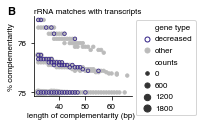

In [19]:
#Plot matches for complementarity between rRNA and genes using Stellar homology search
loc = plticker.MultipleLocator(base=1.0)
panel_name = 'S5B'

plot = Plotter(corners = [0.14, 0.24, 0.52, 0.67], figsize = (sfig*1.65, sfig))

plot.nudge_corners(left = True, right = True)
plot.setup_axis()

plot.ax = sns.scatterplot(x = 'length', y = 'percent_id', size = 'counts', data = bdf, hue = 'gene type',
                          hue_order = ['decreased', 'other'], edgecolor = 'face', 
                          palette = [color_dict['indigo'], color_dict['grey']])

#set the decreased genes to unfilled circles
indigo = np.array(matplotlib.colors.to_rgba(color_dict['indigo']))
collections = plot.ax.collections
for c in collections:
    facecol = c.get_facecolor()
    c.set_edgecolor(facecol)
    ec = c.get_edgecolor()
    #match indigo ones to transparent
    new_colors  = ['none' if (i == indigo).all() else i for i in facecol]
    c.set_facecolor(new_colors)

plot.ax.yaxis.set_major_locator(loc)

plot.set_ylabel('% complementarity')
plot.set_xlabel('length of complementarity (bp)', nudge = (-0.01, 0))
#plot.ax.text(0.5, 1.04, 'rRNA matches with transcripts', ha = 'center', transform = plot.ax.transAxes, fontsize = label_fontsize)
plot.ax.text(0, 1.04, 'rRNA matches with transcripts', ha = 'left', transform = plot.ax.transAxes, fontsize = label_fontsize)
plot.ax.legend(ncol = 1, fontsize = label_fontsize, bbox_to_anchor= (1, 1), handletextpad = 0)

plot.add_letter('B')
plt.savefig(os.path.join(outdir2, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

decreased_gene_aln = dcount['counts'].sum()
other_gene_aln = ocount['counts'].sum()
total_aln = decreased_gene_aln + other_gene_aln
percent_decreased_aln = decreased_gene_aln*100/total_aln

print('total alignments', total_aln)
print('decreased', decreased_gene_aln)
print('other', other_gene_aln)
print('percent of decreased alns', percent_decreased_aln)